# Feature extraction using 1/3 octave filters


## 1. Preparing a csv-file


In [89]:
import csv 

user_mode = False

In [90]:
if user_mode == 'y':
    csv_name = input("give your csv-file a name: ") + '.csv'
else:
    csv_name = "th_oct_feature.csv"

n_th_octvs = 31
n_classes = 10
header = 'fn class'
for i in range(1, n_th_octvs):
    header += f' th_octv{i}'
header = header.split()

csv_fp = 'Datasets/Feature_extraction/' + csv_name
csv_file = open(csv_fp, 'w', newline='')
with csv_file:
    writer = csv.writer(csv_file)
    writer.writerow(header)

## 2. Filter calculation


In [91]:
# core params:

fs = 48000
fmin = 20
fmax = 20000
oct_bw_ratio = 1/3  # octave / amount of subdivisions
ord = 6
dec_iir_ord = 2

n_coeffs_p_section = 6
n_sections = ord / 2

# this is weird to calculate automatically and stays constant anyways
dec_factor = [  1, 1, 1, 1, 
                2, 2, 2, 
                4, 4, 4, 
                8, 8, 8, 
                16, 16, 16, 16, 
                16, 16, 16, 16, 
                16, 16, 16, 16, 
                16, 16, 16, 16, 
                16, 16]

frame_size = 48000
window_size = 1024


padded_sample_sec = fs + 128
max_dur = 5
start_frame = 0
non_zero_c = 1e-20

std_csv_fp = "Datasets/Feature_extraction/th_oct_coeffs.csv"
std_scaling_fp = "Datasets/Feature_extraction/scalings.csv"
# test_wav = "demo_data/191687-3-0-5.wav"
test_wav = "demo_data/sine1k.wav"

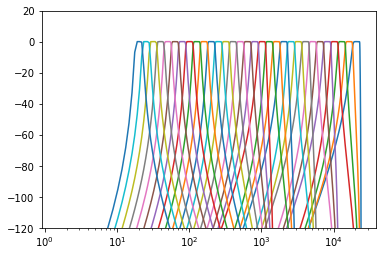

In [92]:
import octafilt3r.filter as o3

fcs, fls, fus, n_bands = o3.gen_fc_fl_fu(fmax, fmin, oct_bw_ratio)

for i in range(n_bands):
    sos = o3.gen_bandpass(int(fs/dec_factor[i]), fls[i], fus[i], _order=ord, _display=True) 

## 3. Calculate values


In [93]:
import numpy as np
from scipy import signal as sg
import librosa as lr
import octafilt3r.filter as o3
import PyOctaveBand.PyOctaveBand as pob
import matplotlib.pyplot as plt


x, sr = lr.load(test_wav, sr=fs, duration=5)

# spl_a = np.zeros(n_bands)
# spl_b = np.zeros(n_bands)

# # my filter
# spl_a = o3.oct_filterbank(buffer, n_bands, dec_factor, dec_iir_ord, fs, fls, fus)

# # open source filter
# spl_b, freq = pob.octavefilter(buffer, fs=fs, fraction=3, order=6, limits=[20, 20000], show=1)



## 4. Display data


In [94]:
# print(spl_a)
# o3.plot_bins(fcs, spl_a)
# o3.plot_bins(freq, spl_b)

# o3.plot_bode(fcs, spl_a)
# o3.plot_bode(freq, spl_b)

## 4. Store features


In [95]:
# import os
# import pandas as pd

# def envelope(y, collection_rate, threshold):
#     mask = []
#     y = pd.Series(y).apply(np.abs)
#     y_mean = y.rolling(window=int(collection_rate/10), min_periods=1, center=True).mean()
#     for mean in y_mean:
#         if mean > threshold:
#             mask.append(True)
#         else:
#             mask.append(False)
#     return mask, y_mean


# def archive_features(classes, main_dir, csv_name):
#     for i in classes:
#         for filename in os.listdir(f'{main_dir}{i}'):
#             wav = f'{main_dir}{i}/{filename}'
#             y, sr = lr.load(wav, mono=True, duration=5)
        
#             # envelope and cut
#             mask, y_mean = envelope(y, 1000, 0.001)
#             y = y[mask]
        
#             # feature extraction
#             spl = o3.oct_filterbank(y, sr)
        
#             # writing feature data to csv file
#             to_append = f'{filename} {np.mean(chroma_stft)} {np.mean(rms)} {np.mean(spec_cent)} {np.mean(spec_bw)} {np.mean(rolloff)} {np.mean(zcr)}'    
#             for e in mfcc:
#                 to_append += f' {np.mean(e)}'
#             to_append += f' {i}'
#             file = open(csv_name, 'a', newline='')
#             with file:
#                 writer = csv.writer(file)
#                 writer.writerow(to_append.split())
#     return _y

In [96]:
def oct_filterbank(x, n_bands, dec_factor, dec_iir_ord, fs, fls, fus, display=False, window_size=1024):

    if int(len(x) / window_size) * window_size < len(x):
        pad = np.zeros(window_size - (len(x) % window_size))

    elif len(x) < window_size:
        pad = np.zeros(window_size - (len(x)))

    else:
        pad = []

    x = np.append(x, pad)
    n_frames = int(len(x)/window_size)
    oct_features = np.zeros((n_frames, n_bands))

    for frame in range(n_frames):

        frame_buf = x[(frame * window_size):((frame + 1) * window_size)]
        spl = np.zeros(n_bands)
        for band in range(n_bands):

            if dec_factor[band] == 1:
                x_dec = frame_buf
            elif dec_factor[band] <= 8:
                x_dec = sg.decimate(frame_buf, dec_factor[band], n=dec_iir_ord)
            else:
                x_dec = sg.decimate(frame_buf, int(dec_factor[band]/(dec_factor[band]/8)), n=dec_iir_ord)
                x_dec = sg.decimate(x_dec, int(dec_factor[band]/8), n=dec_iir_ord)

            cur_sos = o3.gen_bandpass(_fs=int(fs/dec_factor[band]), _fl=fls[band], _fu=fus[band], _display=display)
            sig_out = sg.sosfilt(cur_sos, x_dec)
            ms = o3.rms(sig_out, root=False)
            spl[band] = 10 * np.log10((ms + non_zero_c) / 2e-5)    # safeguard against log(0)

        oct_features[frame] = spl

    return oct_features

test = oct_filterbank(x, n_bands, dec_factor, dec_iir_ord, fs, fls, fus)
# for frame in range(len(test)):
#     o3.plot_bins(fcs, test[frame])
    

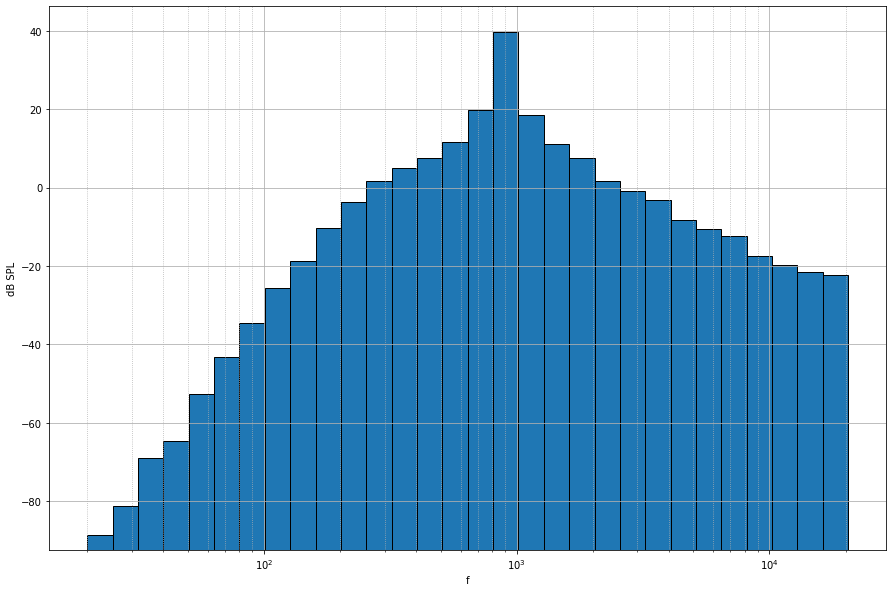

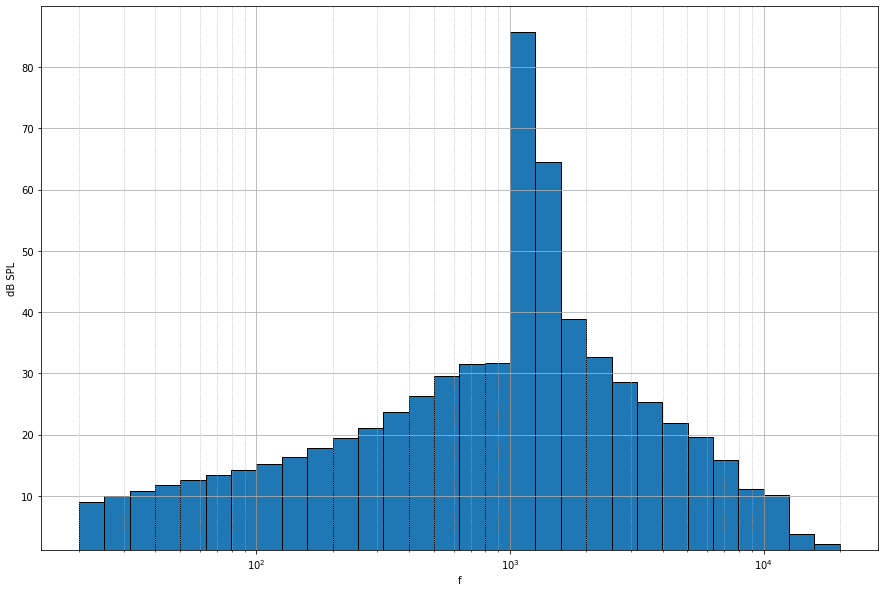

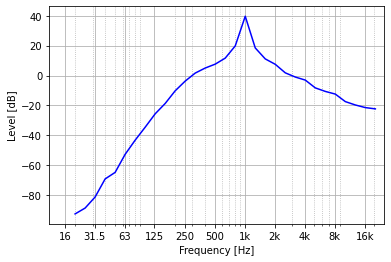

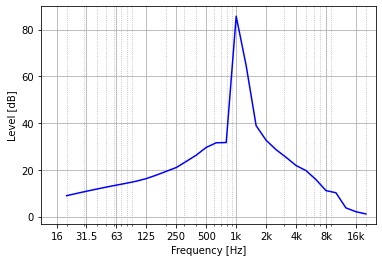

In [97]:
test2, freq = pob.octavefilter(x, fs, 3, order=6, limits=[20, 20000])

p = 0
o3.plot_bins(fcs, test[p])
o3.plot_bins(freq, test2)

o3.plot_bode(fcs, test[p])
o3.plot_bode(freq, test2)